# Coursework



#### I. Environment

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import gym
from gym import Env, logger, spaces, utils

Task 1: 

* Create class for the grid (6x6) where the agent will move/learn: 

In [8]:
class gridEnv(gym.Env):
    def __init__(self, mapsize=(6, 6), princess_position=(4, 4), dragon_position=(3,2), ladder_position=(1,1)):
        super(gridEnv, self).__init__()
        
        # Define the size of the grid 
        self.mapsize = mapsize
        
        # Position of goal: Princess Peach
        self.princess_position = princess_position

        # Position of obstacle: dragon
        self.dragon_position = dragon_position

        # Position of tool: Ladder
        self.ladder_position = ladder_position  
        
        # Define action space: left, right, up, down
        self.action_space = spaces.Discrete(4)
        
        # Define observation space
        self.observation_space = spaces.Box(low=0, high=max(self.mapsize), shape=(2,), dtype=np.int32)
        
        # Define state
        self.state = np.array([1, 0])  # Mario starts at (0, 0)
        self.grid = np.zeros(self.mapsize)  

        # Define if terminal state reached = learning episode ended
        self.done = False 
    
    def reset(self):
        # Reset the Mario's position and the grid
        self.state = np.array([1, 0])  
        self.done = False
        
        # Reset the grid (zeros) and place the goal position
        self.grid = np.zeros(self.mapsize)
        self.grid[self.princess_position[0], self.princess_position[1]] = 2  
        self.grid[self.dragon_position[0], self.dragon_position[1]] = 3
        self.grid[self.ladder_position[0], self.dragon_position[1]] = 4
        
        return self.state

    
    def step(self, action):
        # Move Mario based on the action: up, down, left, right
        if action == 0:  # Move up
            self.state[0] = max(0, self.state[0] - 1)
        elif action == 1:  # Move down
            self.state[0] = min(self.mapsize[0] - 1, self.state[0] + 1)
        elif action == 2:  # Move left
            self.state[1] = max(0, self.state[1] - 1)
        elif action == 3:  # Move right
            self.state[1] = min(self.mapsize[1] - 1, self.state[1] + 1)

        # Check if Mario(agent) saved Princess Peach(terminal state)
        if np.array_equal(self.state, self.princess_position):
            reward = 100
            self.done = True
            
        # Check if Mario faced a dragon     
        elif np.array_equal(self.state, self.dragon_position):
            reward = -30
        # Check if Mario picked up ladder   
        elif np.array_equal(self.state, self.ladder_position):
            reward = 20
            
        # Any other step is penalised to reduce number of steps taken per episode   
        else: 
            reward = -0.5  
        
        return self.state, reward, self.done, {}


    def render(self, mode='human'):
        # Clear the grid and update it with the agent's current position
        self.grid = np.zeros(self.mapsize)
        # Mario
        self.grid[self.state[0], self.state[1]] = 1
        # Princess Peach
        self.grid[self.princess_position[0], self.princess_position[1]] = 2
        
        # Dragon 1,2
        self.grid[self.dragon_position[0], self.dragon_position[1]] = 3
        self.grid[self.ladder_position[0], self.ladder_position[1]] = 4
        
        # Plot the grid
        plt.imshow(self.grid, cmap='Blues', interpolation='nearest')
        #plt.xticks([])  
        #plt.yticks([])  
        plt.show()




#### Vi: Task 2 

2.1. State transition function: Deterministic 

- always moves the same distance per action 
- Dragon: stay in the same place 
- Ladder, (weapon): same place
  
------- 
2.2. Actions: 

- s=(x,y) - Mario's current state 
- Up (0), Down (1),Left (2),Right (3)
  
------- 
2.3. Deterministic Transition function:

(0,0) 
T(s,a) = 
- Up (0): (x, y+1) if a=0 and y<5 
- Down (1): (x, y-1) if a=1 and y>0 
- Left (2): (x-1, y) if a=2 and x>0 
- Right (3): (x+1, y) if a=3 and x<5
  

#### II. Q-learning policy

Task 3 - 6

Set-up q-table of zeros: size is number of states and actions space

In [9]:
def state_to_index(state, width):
    return state[0] * width + state[1]

# Q-learning algorithm
def q_learning(env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, episodes=10):
    # Initialize Q-table with shape (36, 4)
    q_table = np.zeros((env.mapsize[0] * env.mapsize[1], env.action_space.n))
    
    for _ in range(episodes):
        state = tuple(env.reset())
        state_index = state_to_index(state, env.mapsize[1])  # Convert state to index
        done = False
        
        while not done:
            # Choose action based on epsilon-greedy strategy
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(q_table[state_index])
            
            # Take the action and observe the result
            next_state, reward, done, _ = env.step(action)
            next_state = tuple(next_state)
            next_state_index = state_to_index(next_state, env.mapsize[1])  # Convert next state to index
            
            # Update Q-table based on the Q-learning formula
            q_table[state_index, action] += alpha * (reward + gamma * np.max(q_table[next_state_index]) - q_table[state_index, action])
            
            # Move to the next state
            state = next_state
            state_index = next_state_index  # Update the state index
        
        # Decay epsilon to reduce exploration over time
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
    
    return q_table


/Applications/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


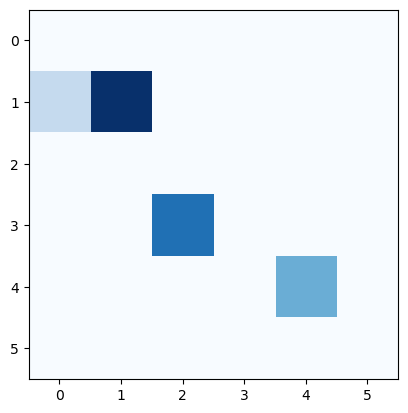

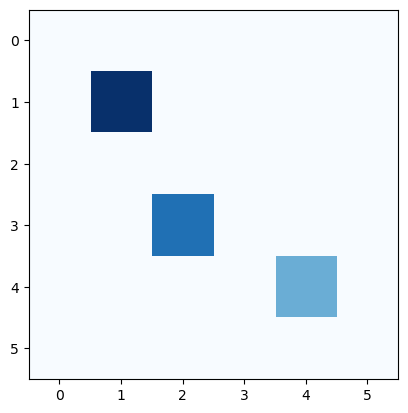

Action: 3, State: [1 1], Reward: 20, Done: False


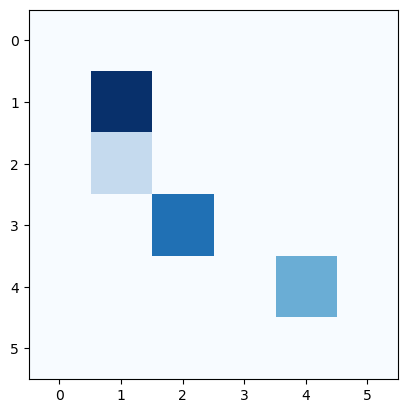

Action: 1, State: [2 1], Reward: -0.5, Done: False


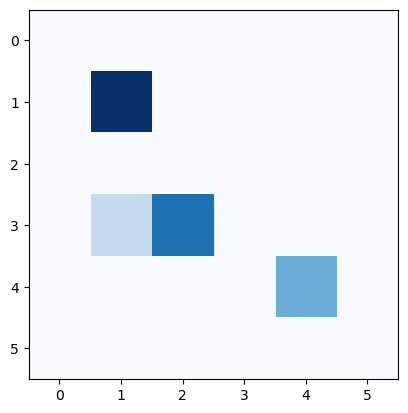

Action: 1, State: [3 1], Reward: -0.5, Done: False


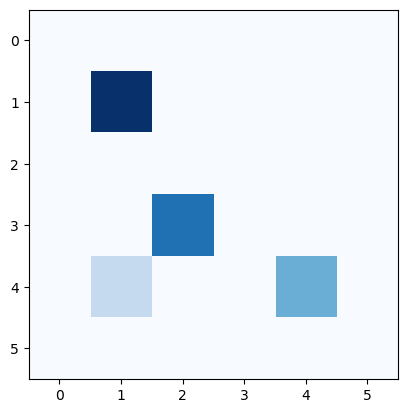

Action: 1, State: [4 1], Reward: -0.5, Done: False


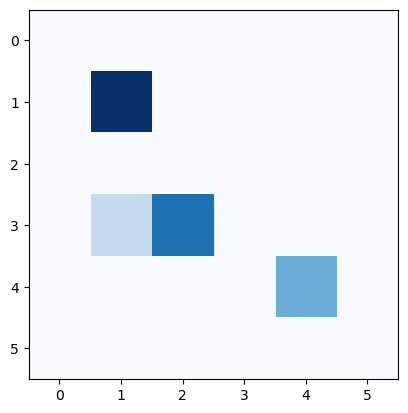

Action: 0, State: [3 1], Reward: -0.5, Done: False


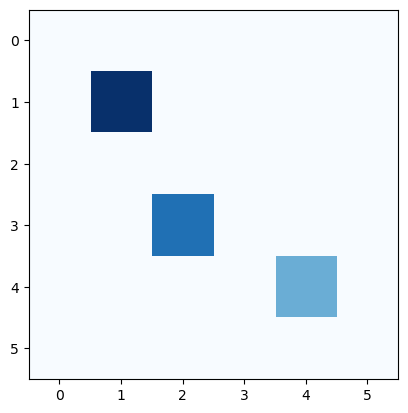

Action: 3, State: [3 2], Reward: -30, Done: False


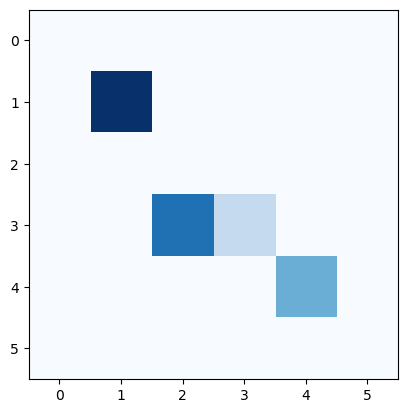

Action: 3, State: [3 3], Reward: -0.5, Done: False


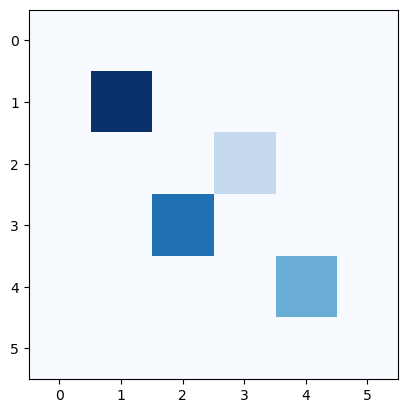

Action: 0, State: [2 3], Reward: -0.5, Done: False


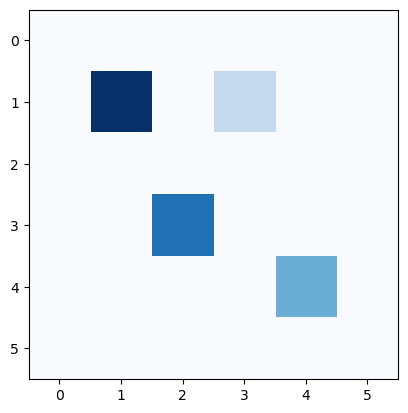

Action: 0, State: [1 3], Reward: -0.5, Done: False


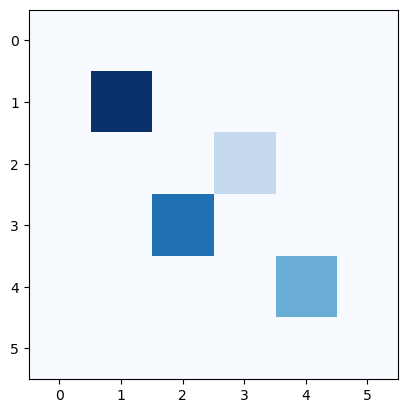

Action: 1, State: [2 3], Reward: -0.5, Done: False


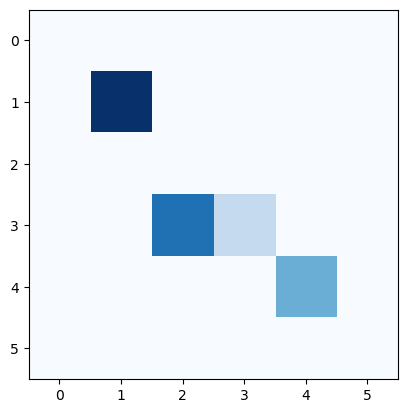

Action: 1, State: [3 3], Reward: -0.5, Done: False


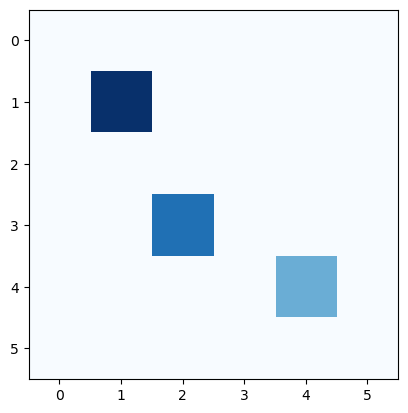

Action: 2, State: [3 2], Reward: -30, Done: False


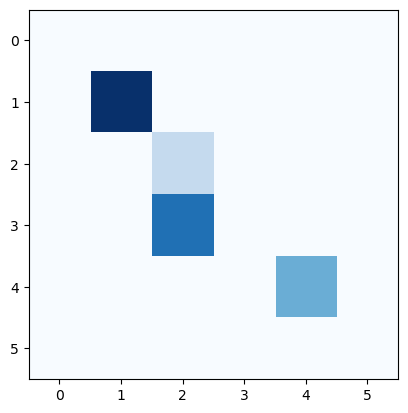

Action: 0, State: [2 2], Reward: -0.5, Done: False


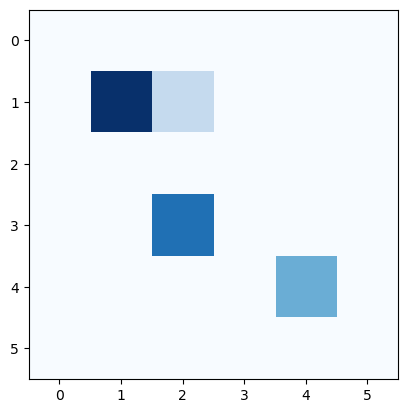

Action: 0, State: [1 2], Reward: -0.5, Done: False


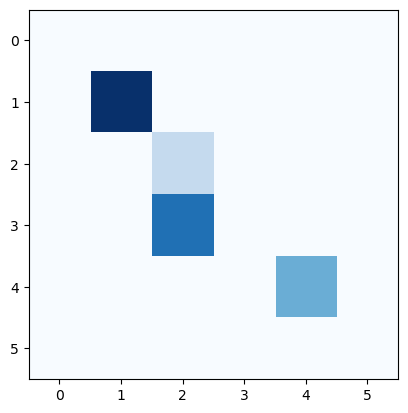

Action: 1, State: [2 2], Reward: -0.5, Done: False


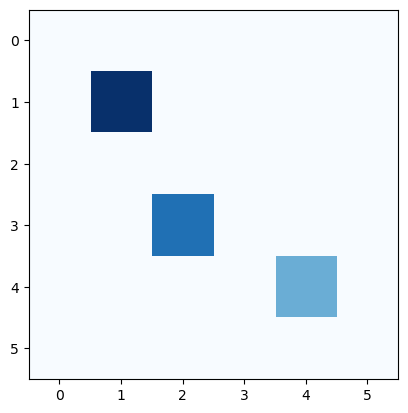

Action: 1, State: [3 2], Reward: -30, Done: False


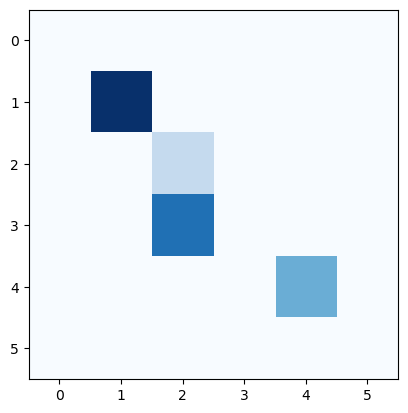

Action: 0, State: [2 2], Reward: -0.5, Done: False


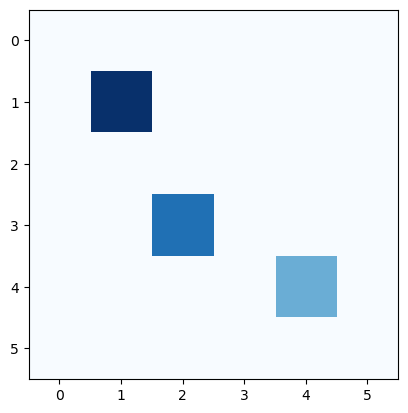

Action: 1, State: [3 2], Reward: -30, Done: False


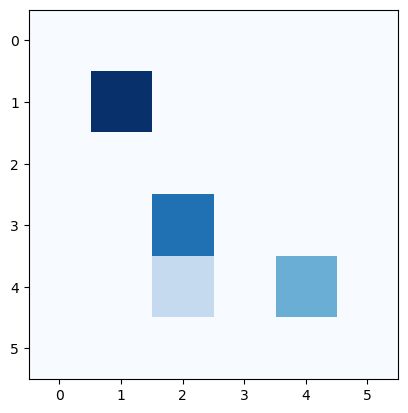

Action: 1, State: [4 2], Reward: -0.5, Done: False


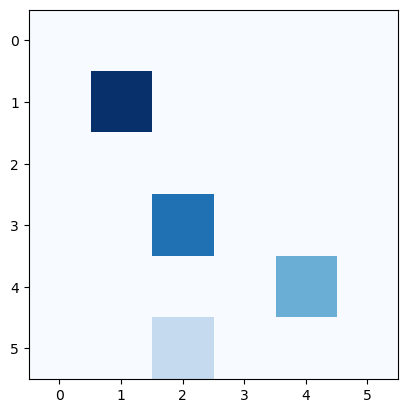

Action: 1, State: [5 2], Reward: -0.5, Done: False


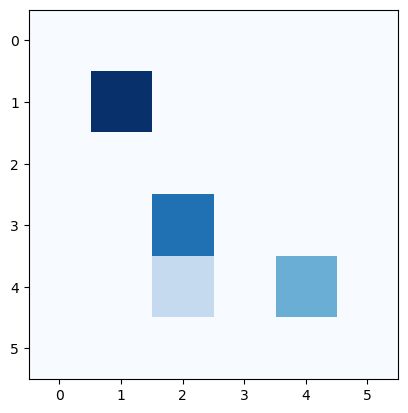

Action: 0, State: [4 2], Reward: -0.5, Done: False


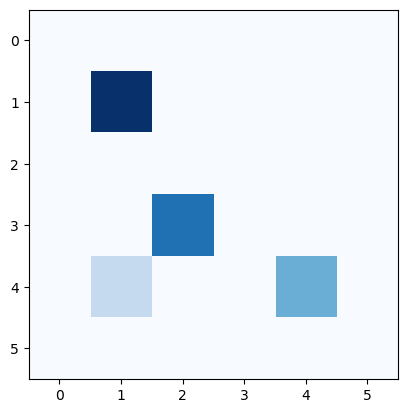

Action: 2, State: [4 1], Reward: -0.5, Done: False


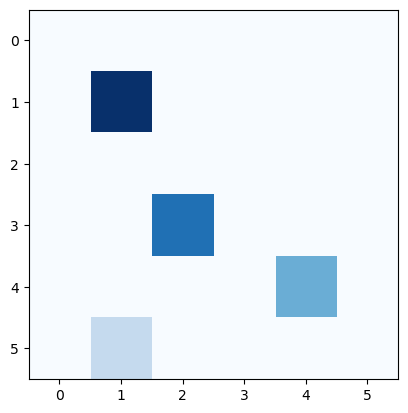

Action: 1, State: [5 1], Reward: -0.5, Done: False


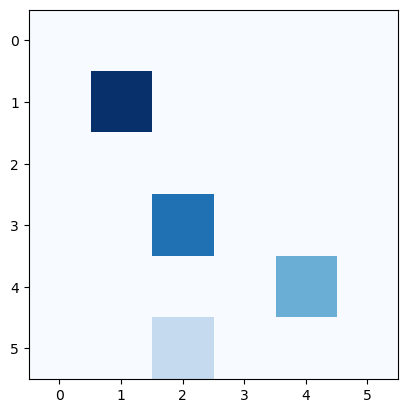

Action: 3, State: [5 2], Reward: -0.5, Done: False


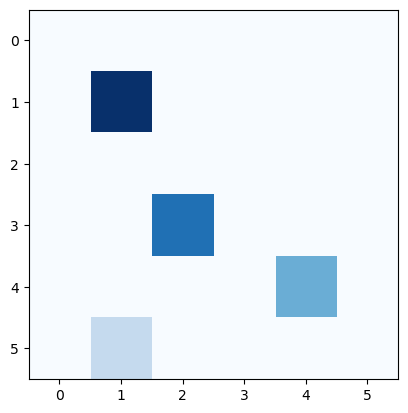

Action: 2, State: [5 1], Reward: -0.5, Done: False


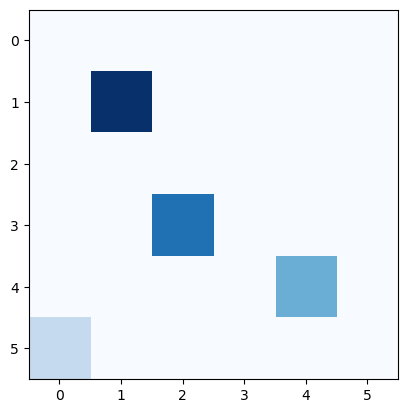

Action: 2, State: [5 0], Reward: -0.5, Done: False


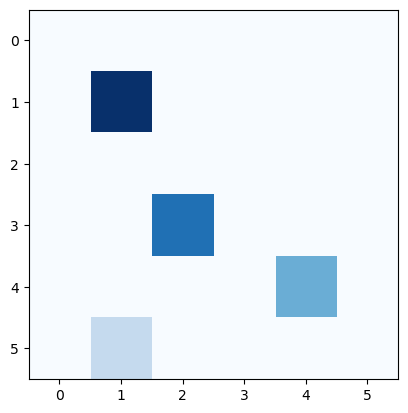

Action: 3, State: [5 1], Reward: -0.5, Done: False


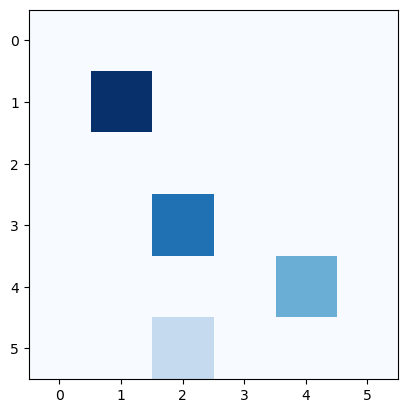

Action: 3, State: [5 2], Reward: -0.5, Done: False


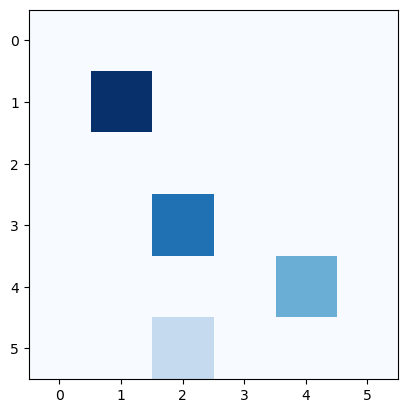

Action: 1, State: [5 2], Reward: -0.5, Done: False


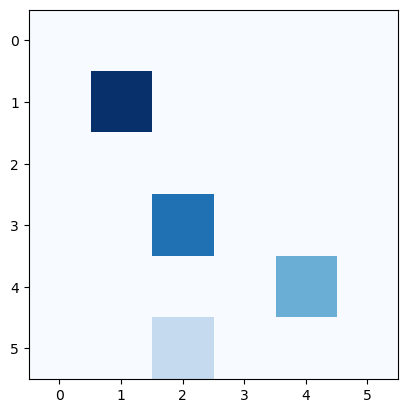

Action: 1, State: [5 2], Reward: -0.5, Done: False


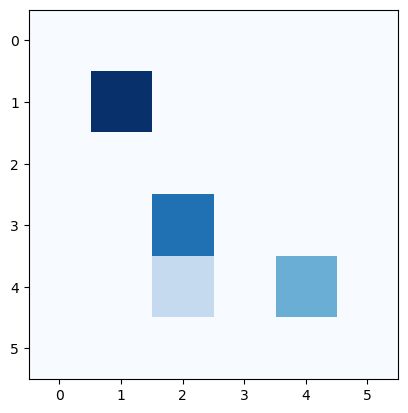

Action: 0, State: [4 2], Reward: -0.5, Done: False


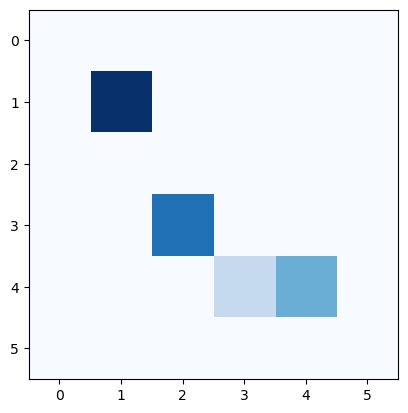

Action: 3, State: [4 3], Reward: -0.5, Done: False


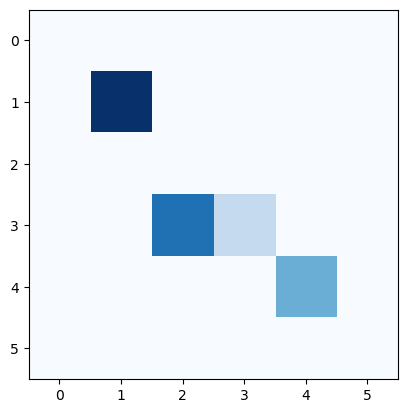

Action: 0, State: [3 3], Reward: -0.5, Done: False


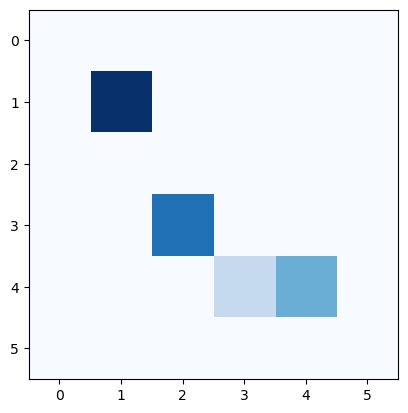

Action: 1, State: [4 3], Reward: -0.5, Done: False


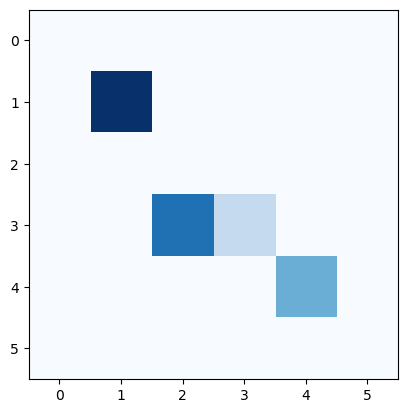

Action: 0, State: [3 3], Reward: -0.5, Done: False


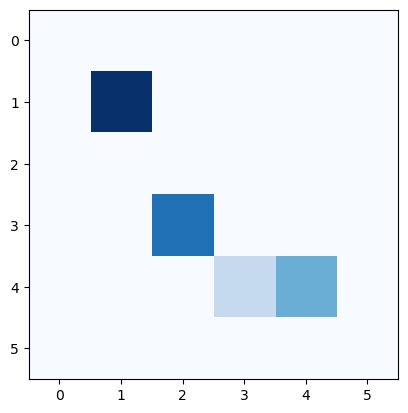

Action: 1, State: [4 3], Reward: -0.5, Done: False


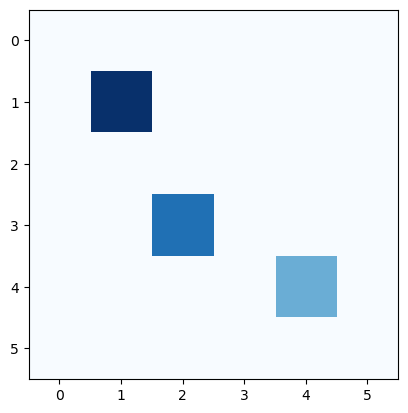

Action: 3, State: [4 4], Reward: 100, Done: True
Trained Q-Table:
[[ 5.10192028e+00  4.44413359e+00  4.60245477e+00  1.04252368e+01]
 [ 5.68251107e+00  1.69837111e+01  4.07980444e+00  1.91596474e+00]
 [ 9.73393926e-01  5.87746357e+00  4.46861751e+00  3.59799132e-02]
 [ 1.58243250e-02  1.57999016e-01  1.32819306e+00 -2.22178921e-01]
 [-2.35976134e-01  2.25375347e-01 -1.03836447e-02 -1.04895050e-01]
 [-9.99500000e-02 -2.14146785e-01 -1.26637129e-01 -2.31494178e-01]
 [ 3.95339963e+00  6.54857694e-01  4.32790745e+00  1.24619450e+01]
 [ 8.42511284e+00  3.32711075e+00  2.75178636e+00  4.29684528e+00]
 [ 8.22707442e-01  1.51940270e-01  1.25609522e+01  5.09794794e-01]
 [ 1.34475333e-01 -1.29741433e-01  2.78667890e+00  2.43661556e-02]
 [-1.67972017e-01  2.06656025e+00  2.58634318e-01 -3.17917443e-01]
 [-2.53080095e-01 -2.55375521e-02  3.00667690e-01 -3.05589015e-01]
 [ 1.72679783e+00 -2.06876579e-01 -6.71612000e-02  3.78600766e+00]
 [ 1.14729183e+01  9.03935601e-02  5.27026847e-01  2.39068239e-

In [10]:
# Test the custom environment with a grid
if __name__ == "__main__":
    env = gridEnv()
    state = env.reset()
    env.render()
    
    done = False
    while not done:
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        env.render()
        print(f"Action: {action}, State: {state}, Reward: {reward}, Done: {done}")

    q_table = q_learning(env)
    print("Trained Q-Table:")
    print(q_table)
        

#### III. Deep Q-Learning

Task 7-8

#### IV. Advanced Tasks

Task 9-11